# Wokflow  **TEST** con Full Bayesiana 

## Inicializacion

In [1]:
# limpio la memoria
Sys.time()
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

[1] "2025-11-15 20:58:22 UTC"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,658612,35.2,1454587,77.7,1318581,70.5
Vcells,1222191,9.4,8388608,64.0,1975163,15.1


In [2]:
plocal <- list()

# 501
plocal$qcanaritos <- 5L
plocal$min_data_in_leaf <- 2000L
plocal$learning_rate <- 1.0
plocal$gradient_bound <- 0.01


plocal$APO <- 1
plocal$ksemillerio <- 1


In [3]:
PARAM <- list()
PARAM$experimento <- "apo-506_d"
PARAM$semilla_primigenia <- 111119

In [4]:
setwd("/content/buckets/b1/exp")
experimento_folder <- PARAM$experimento
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

## Preprocesamiento

### Generacion de la clase_ternaria

In [5]:
Sys.time()
require( "data.table" )

# leo el dataset
dataset <- fread("~/datasets/competencia_02_crudo.csv.gz" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
  "pos" = .I,
  numero_de_cliente,
  periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 )
]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
  shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente
]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
  ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
  clase_ternaria := "BAJA+1"
]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
  & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
  clase_ternaria := "BAJA+2"
]

# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

rm(dsimple)
gc()
Sys.time()

[1] "2025-11-15 20:58:23 UTC"

Loading required package: data.table



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,767483,41.0,1454587,77.7,1454587,77.7
Vcells,722145018,5509.6,1017395510,7762.2,845997218,6454.5


[1] "2025-11-15 20:58:55 UTC"

In [6]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
201901,BAJA+1,645
201901,BAJA+2,729
201901,CONTINUA,122899
201902,BAJA+1,733
201902,BAJA+2,707
201902,CONTINUA,123961
201903,BAJA+1,708
201903,BAJA+2,751
201903,CONTINUA,124508


### Eliminacion de Features

Completar a gusto LUEGO de realizar un analisis exploratorio de datos.
<br> No necesariamente en esta Segunda Competencia conviele eliminar los mismos campos que en la Primera ...

In [7]:
# Salsa Magica para 202106
dataset[, mprestamos_personales := NULL ]
dataset[, cprestamos_personales := NULL ]
dataset[, active_quarter := NULL ]

### Feature Engineering Intra-Mes

Crear variables nuevas a partir de las existentes dentro del mismo registro, **sin** ir a buscar información histórica.
<br> El siguiente código es un mínimo ejemplo, agregar nuevos features a gusto

In [8]:
# el mes 1,2, ..12 , podria servir para detectar estacionalidad
dataset[, kmes := foto_mes %% 100]

# creo un ctr_quarter que tenga en cuenta cuando
# los clientes hace 3 menos meses que estan
# ya que seria injusto considerar las transacciones medidas en menor tiempo
dataset[, ctrx_quarter_normalizado := as.numeric(ctrx_quarter) ]
dataset[cliente_antiguedad == 1, ctrx_quarter_normalizado := ctrx_quarter * 5.0]
dataset[cliente_antiguedad == 2, ctrx_quarter_normalizado := ctrx_quarter * 2.0]
dataset[cliente_antiguedad == 3, ctrx_quarter_normalizado := ctrx_quarter * 1.2]

# variable extraida de una tesis de maestria de Irlanda, se perdió el link
dataset[, mpayroll_sobre_edad := mpayroll / cliente_edad]

Sys.time()

[1] "2025-11-15 20:58:57 UTC"

### Feature Engineering Historico

In [9]:
if( !require("Rcpp")) install.packages("Rcpp", repos = "http://cran.us.r-project.org")
require("Rcpp")

Loading required package: Rcpp



In [10]:
# se calculan para los 6 meses previos el minimo, maximo y
#  tendencia calculada con cuadrados minimos
# la formula de calculo de la tendencia puede verse en
#  https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/10%3A_Correlation_and_Regression/10.04%3A_The_Least_Squares_Regression_Line
# para la maxíma velocidad esta funcion esta escrita en lenguaje C,
# y no en la porqueria de R o Python

cppFunction("NumericVector fhistC(NumericVector pcolumna, IntegerVector pdesde )
{
  /* Aqui se cargan los valores para la regresion */
  double  x[100] ;
  double  y[100] ;

  int n = pcolumna.size();
  NumericVector out( 5*n );

  for(int i = 0; i < n; i++)
  {
    //lag
    if( pdesde[i]-1 < i )  out[ i + 4*n ]  =  pcolumna[i-1] ;
    else                   out[ i + 4*n ]  =  NA_REAL ;


    int  libre    = 0 ;
    int  xvalor   = 1 ;

    for( int j= pdesde[i]-1;  j<=i; j++ )
    {
       double a = pcolumna[j] ;

       if( !R_IsNA( a ) )
       {
          y[ libre ]= a ;
          x[ libre ]= xvalor ;
          libre++ ;
       }

       xvalor++ ;
    }

    /* Si hay al menos dos valores */
    if( libre > 1 )
    {
      double  xsum  = x[0] ;
      double  ysum  = y[0] ;
      double  xysum = xsum * ysum ;
      double  xxsum = xsum * xsum ;
      double  vmin  = y[0] ;
      double  vmax  = y[0] ;

      for( int h=1; h<libre; h++)
      {
        xsum  += x[h] ;
        ysum  += y[h] ;
        xysum += x[h]*y[h] ;
        xxsum += x[h]*x[h] ;

        if( y[h] < vmin )  vmin = y[h] ;
        if( y[h] > vmax )  vmax = y[h] ;
      }

      out[ i ]  =  (libre*xysum - xsum*ysum)/(libre*xxsum -xsum*xsum) ;
      out[ i + n ]    =  vmin ;
      out[ i + 2*n ]  =  vmax ;
      out[ i + 3*n ]  =  ysum / libre ;
    }
    else
    {
      out[ i       ]  =  NA_REAL ;
      out[ i + n   ]  =  NA_REAL ;
      out[ i + 2*n ]  =  NA_REAL ;
      out[ i + 3*n ]  =  NA_REAL ;
    }
  }

  return  out;
}")

In [11]:
# calcula la tendencia de las variables cols de los ultimos 6 meses
# la tendencia es la pendiente de la recta que ajusta por cuadrados minimos
# La funcionalidad de ratioavg es autoria de  Daiana Sparta,  UAustral  2021

TendenciaYmuchomas <- function(
    dataset, cols, ventana = 6, tendencia = TRUE,
    minimo = TRUE, maximo = TRUE, promedio = TRUE,
    ratioavg = FALSE, ratiomax = FALSE) {
  gc(verbose= FALSE)
  # Esta es la cantidad de meses que utilizo para la historia
  ventana_regresion <- ventana

  last <- nrow(dataset)

  # creo el vector_desde que indica cada ventana
  # de esta forma se acelera el procesamiento ya que lo hago una sola vez
  vector_ids <- dataset[ , numero_de_cliente ]

  vector_desde <- seq(
    -ventana_regresion + 2,
    nrow(dataset) - ventana_regresion + 1
  )

  vector_desde[1:ventana_regresion] <- 1

  for (i in 2:last) {
    if (vector_ids[i - 1] != vector_ids[i]) {
      vector_desde[i] <- i
    }
  }
  for (i in 2:last) {
    if (vector_desde[i] < vector_desde[i - 1]) {
      vector_desde[i] <- vector_desde[i - 1]
    }
  }

  for (campo in cols) {
    nueva_col <- fhistC(dataset[, get(campo)], vector_desde)

    if (tendencia) {
      dataset[, paste0(campo, "_tend", ventana) :=
        nueva_col[(0 * last + 1):(1 * last)]]
    }

    if (minimo) {
      dataset[, paste0(campo, "_min", ventana) :=
        nueva_col[(1 * last + 1):(2 * last)]]
    }

    if (maximo) {
      dataset[, paste0(campo, "_max", ventana) :=
        nueva_col[(2 * last + 1):(3 * last)]]
    }

    if (promedio) {
      dataset[, paste0(campo, "_avg", ventana) :=
        nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratioavg) {
      dataset[, paste0(campo, "_ratioavg", ventana) :=
        get(campo) / nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratiomax) {
      dataset[, paste0(campo, "_ratiomax", ventana) :=
        get(campo) / nueva_col[(2 * last + 1):(3 * last)]]
    }
  }
}

In [12]:
# Feature Engineering Historico
# Creacion de LAGs
setorder(dataset, numero_de_cliente, foto_mes)

# todo es lagueable, menos la primary key y la clase
cols_lagueables <- copy( setdiff(
  colnames(dataset),
  c("numero_de_cliente", "foto_mes", "clase_ternaria")
))

# https://rdrr.io/cran/data.table/man/shift.html

# lags de orden 1
dataset[,
  paste0(cols_lagueables, "_lag1") := shift(.SD, 1, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# lags de orden 2
dataset[,
  paste0(cols_lagueables, "_lag2") := shift(.SD, 2, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# agrego los delta lags
for (vcol in cols_lagueables)
{
  dataset[, paste0(vcol, "_delta1") := get(vcol) - get(paste0(vcol, "_lag1"))]
  dataset[, paste0(vcol, "_delta2") := get(vcol) - get(paste0(vcol, "_lag2"))]
}

Sys.time()

[1] "2025-11-15 21:00:55 UTC"

In [13]:
# parametros de Feature Engineering Historico de Tendencias
PARAM$FE_hist$Tendencias$run <- TRUE
PARAM$FE_hist$Tendencias$ventana <- 6
PARAM$FE_hist$Tendencias$tendencia <- TRUE
PARAM$FE_hist$Tendencias$minimo <- FALSE
PARAM$FE_hist$Tendencias$maximo <- FALSE
PARAM$FE_hist$Tendencias$promedio <- FALSE
PARAM$FE_hist$Tendencias$ratioavg <- FALSE
PARAM$FE_hist$Tendencias$ratiomax <- FALSE

In [14]:
# aqui se agregan las tendencias de los ultimos 6 meses

cols_lagueables <- intersect(cols_lagueables, colnames(dataset))
setorder(dataset, numero_de_cliente, foto_mes)

if( PARAM$FE_hist$Tendencias$run) {
    TendenciaYmuchomas(dataset,
    cols = cols_lagueables,
    ventana = PARAM$FE_hist$Tendencias$ventana, # 6 meses de historia
    tendencia = PARAM$FE_hist$Tendencias$tendencia,
    minimo = PARAM$FE_hist$Tendencias$minimo,
    maximo = PARAM$FE_hist$Tendencias$maximo,
    promedio = PARAM$FE_hist$Tendencias$promedio,
    ratioavg = PARAM$FE_hist$Tendencias$ratioavg,
    ratiomax = PARAM$FE_hist$Tendencias$ratiomax
  )
}

ncol(dataset)
Sys.time()

[1] 915

[1] "2025-11-15 21:02:08 UTC"

## Modelado

No hay modelado, no se hace optimizacion de hiperparametros.

## Produccion

Las decisiones que se toman para la construccion del modelo final son:
* Los positvos son  POS={"BAJA+1", "BAJA+2"}, esta es una meticulosa decisión.
* Se entrena en los treinta meses del intervalo [201901, 202104]
* Se realiza undersampling al 5%
* Se utilizan los hiperparámetros optimos encontrados en la Bayesian Optimization
   * Se escala min_data_in_leaf

### Final Training Strategy

In [15]:
PARAM$train_final$future <- c(202106)

PARAM$train_final$training <- c(
  201901, 201902, 201903, 201904, 201905, 201906,
  201907, 201908, 201909, 201910, 201911, 201912,
  #202001, 202002, 202003, 202004, 202005, 202006,
  202007, 202008, 202009, 202010, 202011, 202012,
  202101, 202102, 202103, 202104
)

PARAM$train_final$undersampling <- 0.05  # Silvana y Sofia

In [16]:
# se filtran los meses donde se entrena el modelo final
dataset_train_final <- dataset[foto_mes %in% PARAM$train_final$training]

In [17]:
# canaritos
PARAM$train_final$lgbm$qcanaritos <- plocal$qcanaritos

cols0 <- copy(colnames(dataset_train_final))
filas <- nrow(dataset_train_final)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dataset_train_final[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dataset_train_final), cols0 ) )
  setcolorder( dataset_train_final, c( cols_canaritos, cols0 ) )
}

Sys.time()

[1] "2025-11-15 21:02:18 UTC"

#### Registros cambio las proporciones de POS/NEG

In [18]:
# Undersampling, van todos los "BAJA+1" y "BAJA+2" y solo algunos "CONTINIA"

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train_final[, azar := runif(nrow(dataset_train_final))]
dataset_train_final[, training := 0L]

dataset_train_final[
  (azar <= PARAM$train_final$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

dataset_train_final[, azar:= NULL] # elimino la columna azar

### Target Engineering

In [19]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train_final[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

### Final Models

Aqui SIEMPRE voy a hacer un semillerio, independientemente de si en la Bayesian Optimization calculé un semillerio en cada iteración.
<br> Entreno un LightGBM para cada semilla,  y guardo el modelo dentro de la carpeta  **modelitos**
<br> Intencionalmente en una primera etapá se generan los modelos y graban, y en una segunda etapa se leen eso modelos y se aplican a los datos del futuro

APO controla cuantas veces se repite el modelo, que se usa para promediar ganancias y reportar en la Pseudo Competencia algo razonable
<br> El modelo puede ser un LightGBM simple (ksemillerio==1)  o un Ensemble Semillerio( ksemillerio > 1 )
<br> Lamentablmente APO necesita utilizar muchas semillas, y eso demanda TIEMPO de corrida

In [20]:

PARAM$train_final$lgbm$param_completo <-  list(
  boosting= "gbdt",
  objective= "binary",
  metric= "custom",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE,
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_bin= 31L,
  min_data_in_leaf= plocal$min_data_in_leaf,  #este ya es el valor default de LightGBM

  num_iterations= 9999L, # dejo libre la cantidad de arboles, zLightGBM se detiene solo
  num_leaves= 9999L, # dejo libre la cantidad de hojas, zLightGBM sabe cuando no hacer un split
  learning_rate= plocal$learning_rate,  # se lo deja en 1.0 para que si el score esta por debajo de gradient_bound no se lo escale
    
  feature_fraction= 0.50, # un valor equilibrado, habra que probar alternativas ...
    
  canaritos= PARAM$train_final$lgbm$qcanaritos, # fundamental en zLightGBM, aqui esta el control del overfitting
  gradient_bound= plocal$gradient_bound   # default de zLightGBM
)

Sys.time()

[1] "2025-11-15 21:02:18 UTC"

In [21]:
# Semillerio Final
PARAM$train_final$APO <- plocal$APO
PARAM$train_final$ksemillerio  <- plocal$ksemillerio

PARAM$train_final$cortes <- c(8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000)

In [22]:
# detach("package:lightgbm", unload= TRUE)

In [23]:
if( !require("zlightgbm") ) install.packages("https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/zlightgbm_4.6.0.99.tar.gz", repos= NULL, type= "source")
require("zlightgbm")

Loading required package: zlightgbm



In [24]:
if(!require("primes")) install.packages("primes")
require("primes")

Loading required package: primes



In [25]:
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
PARAM$train_final$semillas <- sample(primos)[seq( PARAM$train_final$APO*PARAM$train_final$ksemillerio )]
PARAM$train_final$semillas

[1] 218989

In [26]:
campos_buenos <- setdiff(
  colnames(dataset_train_final),
  c( "clase_ternaria", "clase01", "training", "azar")
)

In [27]:
# dejo los datos en formato LightGBM
dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train_final[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train_final[training == 1L, clase01],
  free_raw_data= FALSE
)

cat("filas", nrow(dtrain_final), "columnas", ncol(dtrain_final), "\n")
Sys.time()

filas 186344 columnas 919 


[1] "2025-11-15 21:02:22 UTC"

In [28]:
# genero los modelitos
dir.create( "modelitos", showWarnings= FALSE)

param_completo <- copy( PARAM$train_final$lgbm$param_completo)

for( sem in PARAM$train_final$semillas ) {

  arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
  if( !file.exists( arch_modelo ) )
  {
    param_completo$seed <- sem

    modelito <- lgb.train(
      data= dtrain_final,
      param= param_completo
    )

    lgb.save( modelito, filename= arch_modelo)
    rm(modelito)
    gc()
  }
}

Sys.time()

[1] "2025-11-15 22:06:07 UTC"

### Scoring

Se hace el predict() del modelo en los datos del futuro

In [29]:
dfuture <- dataset[foto_mes %in% PARAM$train_final$future ]

cols0 <- copy(colnames(dfuture))
filas <- nrow(dfuture)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dfuture[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dfuture), cols0 ) )
  setcolorder( dfuture, c( cols_canaritos, cols0 ) )
}

In [30]:
# dataset de future, donde en este caso estoy haciendo testing

mfuture <- data.matrix(dfuture[, campos_buenos, with= FALSE])

dfuture[, ganancia := ifelse(clase_ternaria=="BAJA+2", 780000, -20000)]

In [31]:
mganancias <- matrix( nrow=PARAM$train_final$APO, ncol= length(PARAM$train_final$cortes) )

if( file.exists("prediccion.txt") )
  file.remove("prediccion.txt")

In [32]:
# aplico el modelo a los datos del future

for( vapo in seq(PARAM$train_final$APO) ) {
  # inicializacion en CERO
  vpred_acum <- rep(0.0, nrow(dfuture))
  qacumulados <- 0

  desde <- 1 + (vapo-1)*PARAM$train_final$ksemillerio
  hasta <- desde + PARAM$train_final$ksemillerio - 1
  semillas <- PARAM$train_final$semillas[desde:hasta]

  for( sem in semillas ) {

    arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
    if( file.exists( arch_modelo ) )
    {
      modelo_final <- lgb.load(arch_modelo) # leo del disco
      # hago el predict() y acumulo
      vpred_acum <- vpred_acum + predict(modelo_final, mfuture)
      qacumulados <- qacumulados + 1
      rm(modelo_final)
      gc()
    }
  }

  if( qacumulados > 0 ) {
    vpred_acum <- vpred_acum / qacumulados  # paso a probabildiad
    # tabla de prediccion, puede ser util para futuros ensembles
    #  ya que le modelo ganador va a ser un ensemble de LightGBMs

    tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes, ganancia)]
    tb_prediccion[, meta_modelo := vapo]
    tb_prediccion[, prob := vpred_acum ]
    setorder( tb_prediccion, -prob )
    tb_prediccion[, gan_acum := cumsum(ganancia)]
    tb_prediccion[, ganancia := NULL ]

    # acumulo las ganancias
    for( icor in seq(length(PARAM$train_final$cortes)) ){
      mganancias[ vapo, icor ] <- tb_prediccion[ PARAM$train_final$cortes[icor], gan_acum ]
    }

    # grabo las probabilidades del modelo
    fwrite(tb_prediccion,
      file= "prediccion.txt",
      sep= "\t",
      append= TRUE
    )

    rm(tb_prediccion)
    gc()
  }
}

Sys.time()

[1] "2025-11-15 22:06:44 UTC"

In [33]:
mganancias

398400000,395600000,398400000,395600000,397600000,398800000,398400000,399600000,402400000


### Clasificacion

Se tomó la decisión de enviar a los 11000 registros con mayor probabilidad de POS={"BAJA+1","BAJA+"}
<br> esto se determinó en forma artesanal analizando meses anterior
<br> esta es una muy importante decisión 

In [34]:
# genero archivos con los  "envios" mejores
dir.create("kaggle", showWarnings=FALSE)

tb_prediccion <- fread("prediccion.txt")

In [35]:
# genero archivos de fantasia, que NO son el que voy a subir a la Pseudo Competencia Kaggle
envios <- 11000

for( vapo in seq(PARAM$train_final$APO) ) {
  if( tb_prediccion[meta_modelo==vapo, .N] > 0 ) {
    tb_pred <- tb_prediccion[meta_modelo==vapo]
    setorder( tb_pred, -prob )
    tb_pred[, Predicted := 0L] # seteo inicial a 0
    tb_pred[1:envios, Predicted := 1L] # marco los primeros

    archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", vapo, "_", envios, ".csv")

    # grabo el archivo
    fwrite(tb_pred[, list(numero_de_cliente, Predicted)],
      file= archivo_kaggle,
      sep= ","
    )

    rm( tb_pred )
    gc()
  }
}

Sys.time()

[1] "2025-11-15 22:06:45 UTC"

### Subida a Pseudo Kaggle

Aqui viene la verdadera magia de  APO = A Prueba Overfiteres
<br>Se sube un submit a la Pseudo Competencia Kaggle cuya ganancia coincide casi exactamente con la ganancia MEDIA , promediada  APO veces

In [36]:
colmedias <- colMeans( mganancias, na.rm=TRUE )
mcorte_mejor <- max(colmedias, na.rm=TRUE)
icorte_mejor <- which.max( colmedias )
corte_mejor <- PARAM$train_final$cortes[icorte_mejor]

In [37]:
tbl <- as.data.table( as.list( colmedias ) )
colnames(tbl) <- paste0( "e", PARAM$train_final$cortes )
tbl[, experimento := PARAM$experimento ]

exp_gral <- "/content/buckets/b1/exp/apo-gral"
dir.create(exp_gral, showWarnings=FALSE)
fwrite( tbl,
  file= paste0( exp_gral, "/tb_experimentos.txt"),
  sep= "\t",
  append= TRUE
)

In [38]:
colnames( mganancias ) <- paste0( "e", PARAM$train_final$cortes )
tbl_local <- as.data.table( mganancias )

fwrite( tbl_local,
  file= "tb_apo.txt",
  sep= "\t"
)

In [39]:
icerca <- which.min(  abs( tb_prediccion$gan_acum - mcorte_mejor ) )
vmodelo <- tb_prediccion[ icerca, meta_modelo ]
tb_pred <- tb_prediccion[meta_modelo==vmodelo]

mcorte_mejor
icerca
tb_prediccion[ icerca]

[1] 402400000

[1] 10640

numero_de_cliente,foto_mes,meta_modelo,prob,gan_acum
<int>,<int>,<int>,<dbl>,<dbl>
637539639,202106,1,0.3729854,402400000


In [40]:
icerca <- which.min(  abs( tb_pred$gan_acum - mcorte_mejor ) )
icerca

[1] 10640

In [41]:
icerca <- which.min(  abs( tb_prediccion$gan_acum - mcorte_mejor ) )
vmodelo <- tb_prediccion[ icerca, meta_modelo ]
tb_pred <- tb_prediccion[meta_modelo==vmodelo]

icerca <- which.min(  abs( tb_pred$gan_acum - mcorte_mejor ) )
tb_pred[, Predicted := 0L] # seteo inicial a 0
tb_pred[1:icerca, Predicted := 1L] # marco los primeros

archivo_pseudo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_",  icerca, ".csv")

# grabo el archivo
fwrite(tb_pred[, list(numero_de_cliente, Predicted)],
  file= archivo_pseudo_kaggle,
  sep= ","
)


In [42]:
# la subida a Kaggle
comando <- "kaggle competitions submit"
competencia <- "-c  test-202106"
arch <- paste( "-f", archivo_pseudo_kaggle)
mensaje <-  paste0( "-m 'exp=", PARAM$experimento,
  "  ", paste(names(plocal), plocal, sep= "=", collapse= ";" ),
  " envios=", icorte_mejor,"'")

                    
linea <- paste( comando, competencia, arch, mensaje)
salida <- system(linea, intern=TRUE)
cat(salida)

Successfully submitted to Test202106

In [43]:
Sys.time()

[1] "2025-11-15 22:06:49 UTC"

                          Feature         Gain        Cover    Frequency
                           <char>        <num>        <num>        <num>
  1:     ctrx_quarter_normalizado 2.715774e-01 1.098640e-02 6.881817e-03
  2:                 ctrx_quarter 1.331106e-01 5.729470e-03 4.942781e-03
  3:                 mcaja_ahorro 9.598075e-02 9.965730e-03 8.997130e-03
  4:        mtarjeta_visa_consumo 5.428364e-02 8.185518e-03 6.494010e-03
  5:               mcuentas_saldo 3.374170e-02 1.193702e-02 1.342518e-02
 ---                                                                    
718:          Master_mpagado_lag2 2.632637e-07 9.079153e-07 7.051042e-06
719: Master_madelantopesos_delta1 2.603044e-07 9.203824e-07 7.051042e-06
720:        mpagodeservicios_lag1 2.576076e-07 3.689316e-05 7.051042e-06
721:          cseguro_vida_delta2 2.415598e-07 3.420376e-05 7.051042e-06
722:             cinversion1_lag1 1.300578e-07 4.372035e-06 7.051042e-06


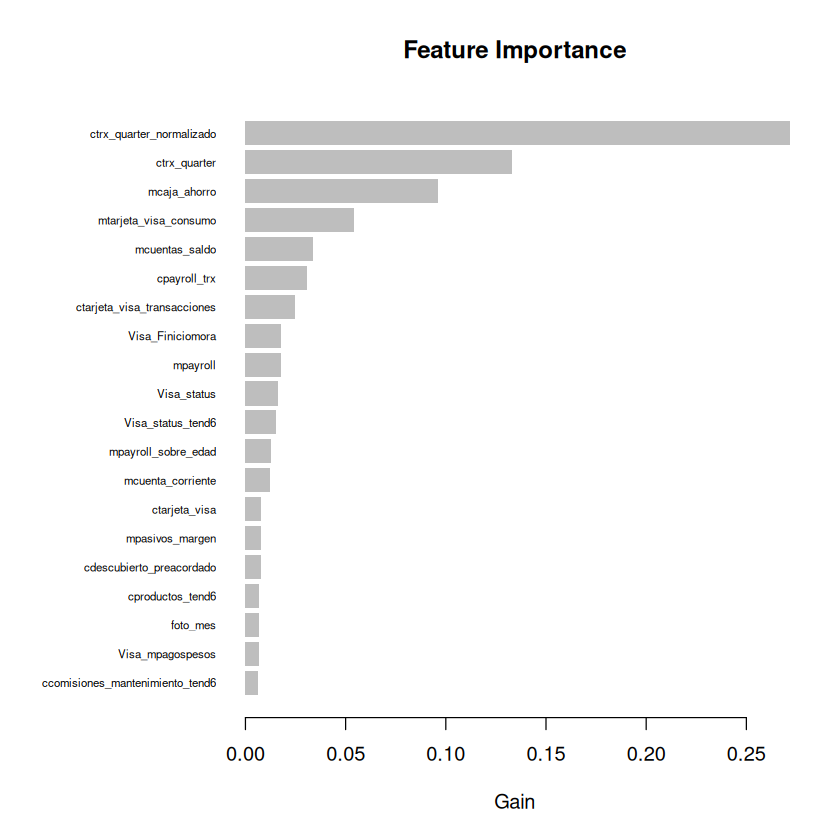

In [46]:
library(lightgbm)

# Cargar un modelo guardado
modelito <- lgb.load("~/buckets/b1/exp/apo-506_d/modelitos/mod_218989.txt")  # reemplazá con tu archivo

# Obtener importancia de variables
importance <- lgb.importance(modelito, percentage = TRUE)
print(importance)

# Graficar importancia
lgb.plot.importance(importance, top_n = 20)  # muestra las 20 más importantes


                           Feature         Gain        Cover    Frequency
                            <char>        <num>        <num>        <num>
  1:      ctrx_quarter_normalizado 2.523692e-01 9.789586e-03 6.224616e-03
  2:                  ctrx_quarter 1.130794e-01 4.557903e-03 4.293952e-03
  3:                  mcaja_ahorro 1.062382e-01 8.552591e-03 8.000310e-03
  4:         mtarjeta_visa_consumo 5.959983e-02 7.371468e-03 5.759707e-03
  5:                  cpayroll_trx 3.645309e-02 8.996469e-03 3.312477e-03
 ---                                                                     
737:         mpagodeservicios_lag1 3.035097e-07 3.149067e-05 6.457070e-06
738:       cpagodeservicios_delta1 2.849645e-07 3.090604e-05 6.457070e-06
739: mtarjeta_visa_descuentos_lag1 2.820179e-07 3.034721e-05 6.457070e-06
740:    ccheques_depositados_tend6 2.181298e-07 3.248108e-05 6.457070e-06
741:                      tcuentas 1.449319e-07 3.413314e-05 6.457070e-06


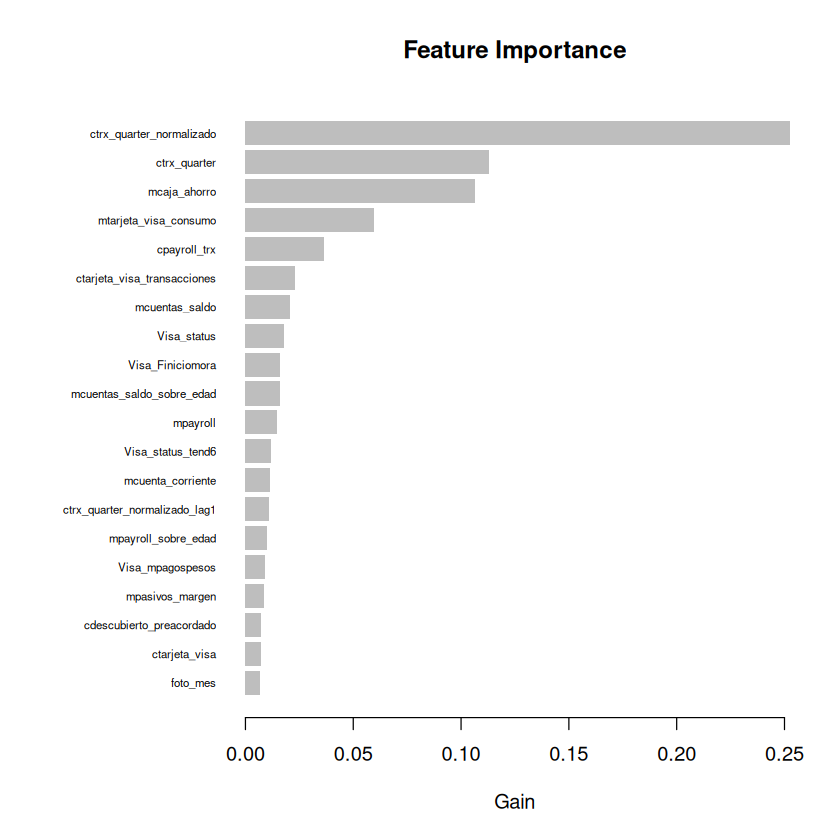

In [48]:
# Cargar un modelo guardado
modelito <- lgb.load("~/buckets/b1/exp/apo-506_c/modelitos/mod_218989.txt")  # reemplazá con tu archivo

# Obtener importancia de variables
importance <- lgb.importance(modelito, percentage = TRUE)
print(importance)

# Graficar importancia
lgb.plot.importance(importance, top_n = 20)  # muestra las 20 más importantes

                        Feature         Gain        Cover    Frequency
                         <char>        <num>        <num>        <num>
  1:   ctrx_quarter_normalizado 2.071733e-01 9.471593e-03 4.130238e-03
  2:               ctrx_quarter 9.634433e-02 5.436704e-03 4.201114e-03
  3:               mcaja_ahorro 8.987490e-02 8.486714e-03 8.170166e-03
  4:                Visa_status 4.218401e-02 2.946726e-03 6.710351e-04
  5:          mcuenta_corriente 4.181566e-02 5.583563e-03 6.944698e-03
 ---                                                                  
852:            mpayroll2_tend6 2.226956e-08 1.012622e-07 1.143160e-06
853:         cseguro_auto_tend6 1.838093e-08 1.214874e-07 1.143160e-06
854:  minversion1_dolares_tend6 6.094002e-09 1.797805e-06 1.143160e-06
855: minversion1_dolares_delta2 5.322148e-09 1.773209e-06 2.286320e-06
856: minversion1_dolares_delta1 7.810857e-10 1.702500e-06 1.143160e-06


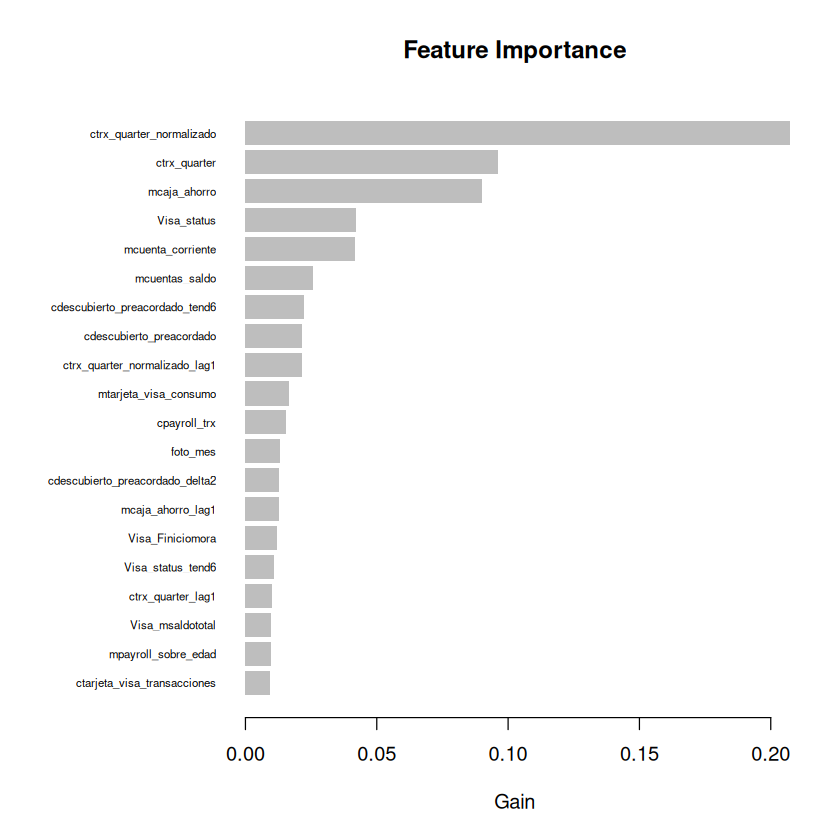

In [50]:
# Cargar un modelo guardado
modelito <- lgb.load("~/buckets/b1/exp/apo-506-0.2undersampling/modelitos/mod_974411.txt")  # reemplazá con tu archivo

# Obtener importancia de variables
importance <- lgb.importance(modelito, percentage = TRUE)
print(importance)

# Graficar importancia
lgb.plot.importance(importance, top_n = 20)  # muestra las 20 más importantes